# Pro tip: if you run the import once you get a lot of warning, but then you just run it again then the warning is gone

In [4]:
import impnb
import herMLE
import Data_processing as dp;
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Import_EEG as IE;
from scipy import stats
import copy

img_path='/cndd/hop006/Processing/PRL_imgs'
behavior_log_path='/cndd/hop006/Github/RewardReversalPorject/BehaviorLog/'
plt_path='/cndd/hop006/Github/RewardReversalPorject/Plots/'
ERP_plot_path='/cndd/hop006/Github/RewardReversalPorject/Plots/ERP/'
PELogs=pd.read_pickle(behavior_log_path+'rat26to38PElog.pkl')
git_data='/cndd/hop006/Github/RewardReversalPorject/Data/epoched_eeg'
behavior_log=pd.read_pickle(git_data+'/26to38behaviors.pickle')
EEGs=pd.read_pickle(git_data+'/26to38EEGs.pickle')

# settings
rat_2_anal=list(set(dp.day1.subject).intersection(set(dp.day21.subject)))
days=2

# Part Zero: Gathering Data - every rat takes about 20s to process
#### Note: Only doing from rat_26 and up, some are not 20 days apart
#### Common electrodes: 
 Ag Disk (frontal center)',
 'L Au1 EEG',
 'L Cerebellum EEG',
 'L NAc LFP',
 'L lOFC LFP',
 'R ACC LFP',
 'R Au1 LFP',
 'R Caudate LFP',
 'R lOFC EEG'}

In [13]:
rat_2_anal=[33, 37, 26, 28] #There is a bug where if the ephys file contains
# two rats the data is off

# DON'T RUN THIS CELL $\Downarrow$

In [53]:
for myrat in rat_2_anal:
    val_chan,chan_name,dates,rat_nums,reward_tone=IE.get_excel_info(myrat)
    rat_rlogs=[]
    rat_alogs=[]
    for day in range(days):
        rat_df=IE.get_ephys(dates[day],rat_nums[day])
#          tvec,signal,low_tone,high_tone,tar,off_tar=IE.rat_summary(rat_df)
        action_log,reward_log,epoched_eeg=IE.get_behavior(rat_df,300,reward_tone,plot=False)
        rat_rlogs.append(reward_log)
        rat_alogs.append(action_log)
        print(myrat,day)
    behavior_log[myrat]={}
    behavior_log[myrat]['reward']=rat_rlogs
    behavior_log[myrat]['action']=rat_alogs

/home/AD/hop006/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


(4, 1371900)
26 0
(4, 1408110)
26 1
(4, 1458630)
28 0
(4, 1395660)
28 1


Import EEG.ipynb:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  "import Data_processing as dp\n",


(4, 1453980)
29 0
(4, 1577820)
29 1
(4, 1343550)
30 0
(4, 1577820)
30 1
(4, 1867320)
31 0
(4, 1419330)
31 1
(4, 1418730)
33 0
(4, 1574130)
33 1
(4, 1622910)
35 0
(4, 1496370)
35 1
(4, 1490610)
36 0
(4, 1496370)
36 1
(4, 1507680)
37 0
(4, 1538760)
37 1


In [9]:
behavior_df=pd.read_pickle(behavior_log_path+'new_rat26to38.pkl')

In [54]:
behavior_df=pd.DataFrame(behavior_log)
behavior_df.to_pickle(behavior_log_path+'new_rat26to38.pkl')

# Part One: Behavior Models
### Model-1: Q-learning with alpha_gain and loss, beta, and sigmoid action decision

### Plots

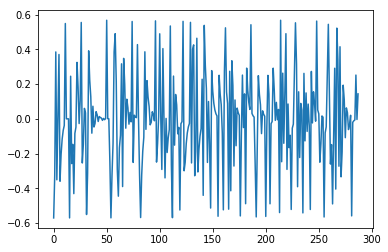

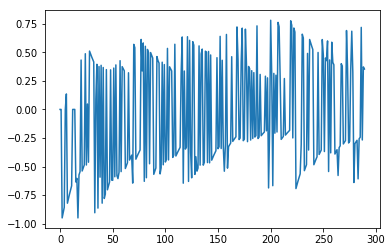

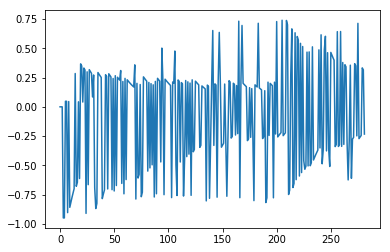

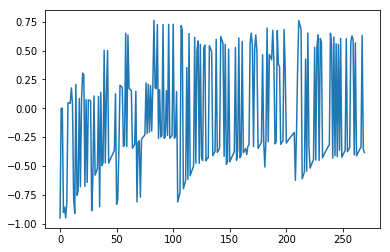

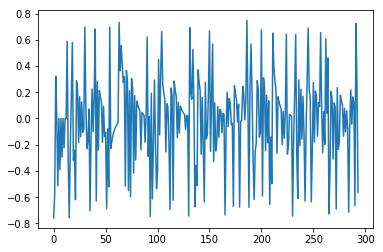

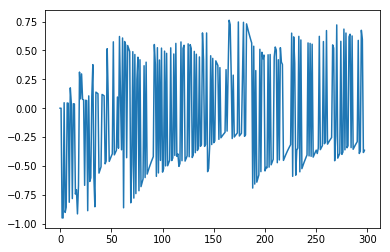

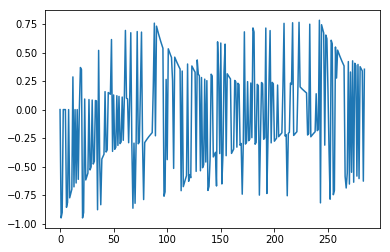

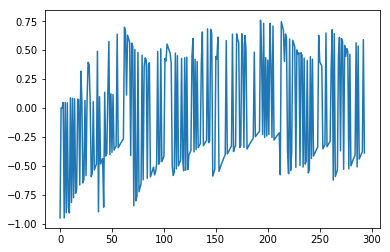

In [14]:
count=1
n=len(rat_2_anal)
for rat in rat_2_anal:
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        plt.figure(count)
        count+=1
#         print(PELogs.iloc[rat][day])
        plt.plot(PELogs.loc[flag][0])


# Four conditions and PE

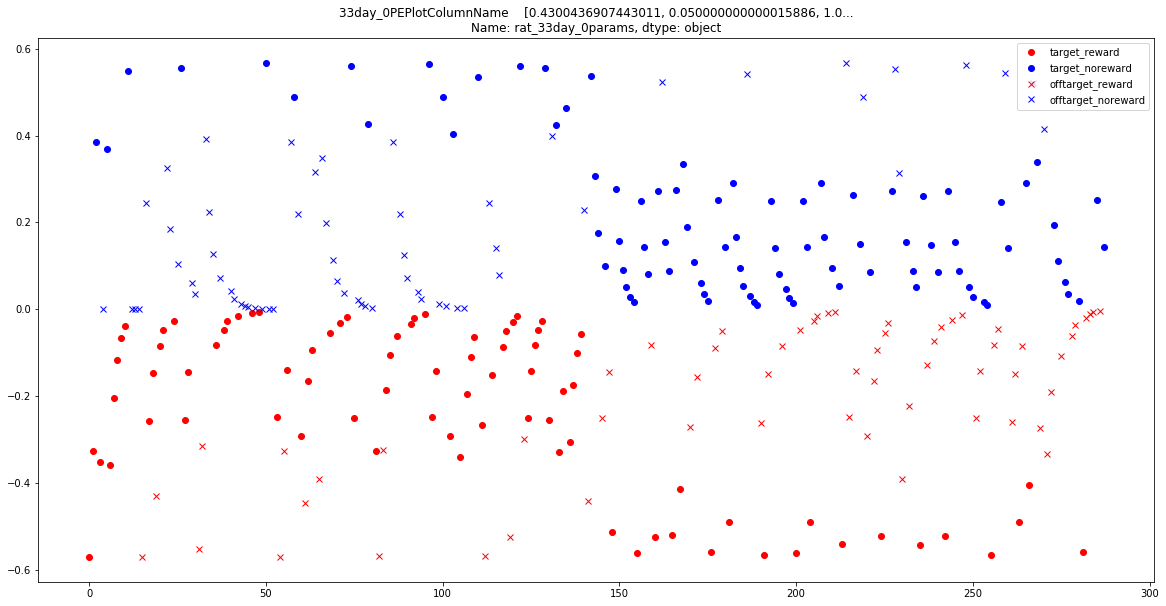

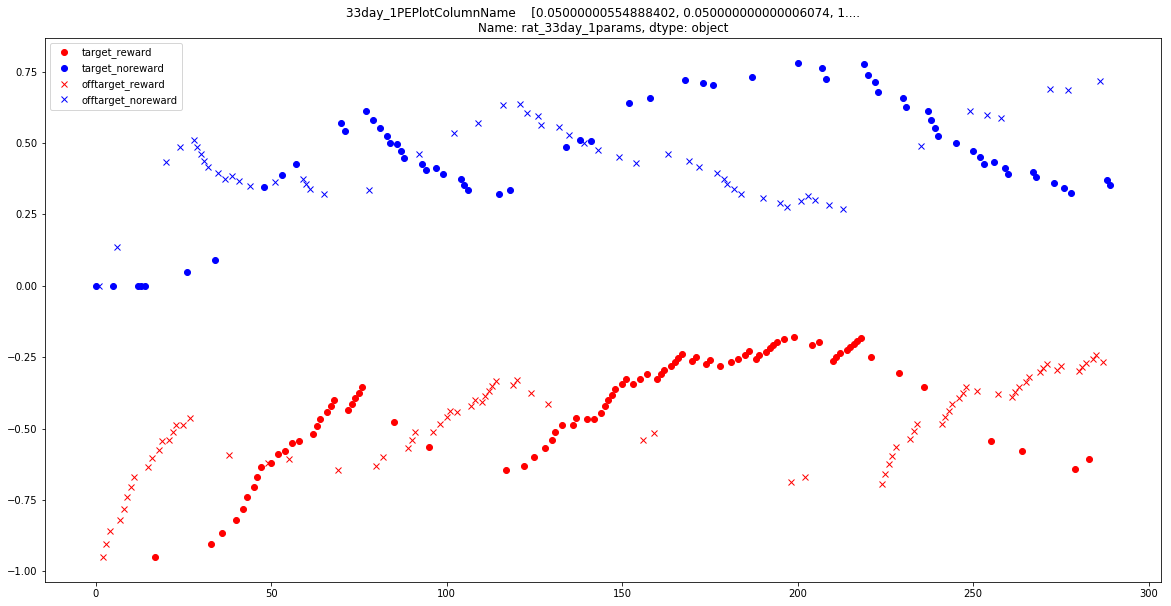

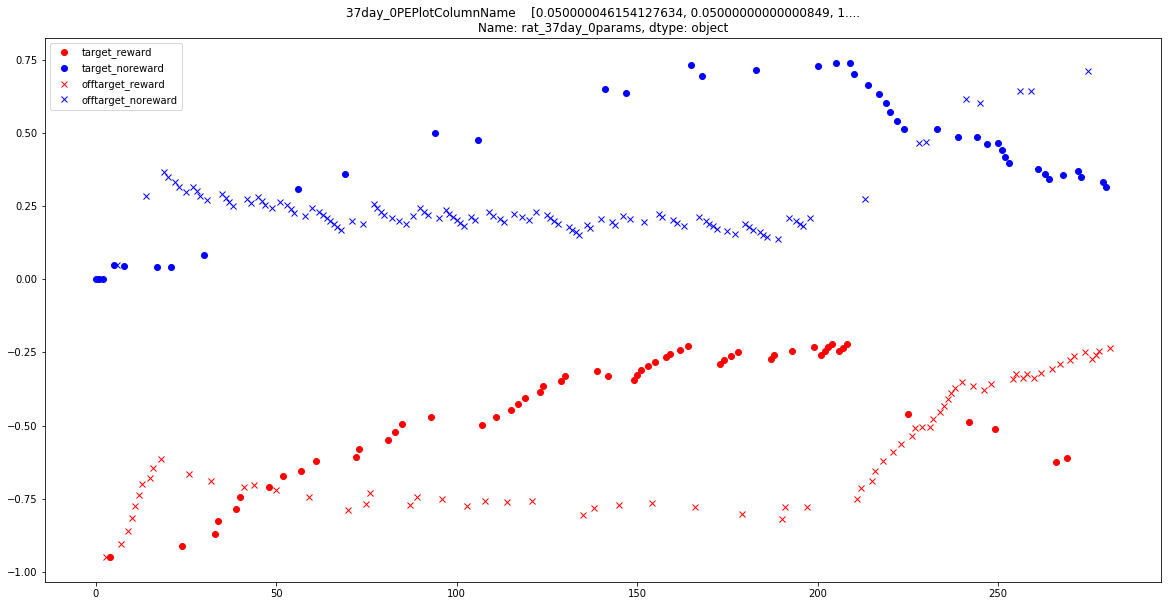

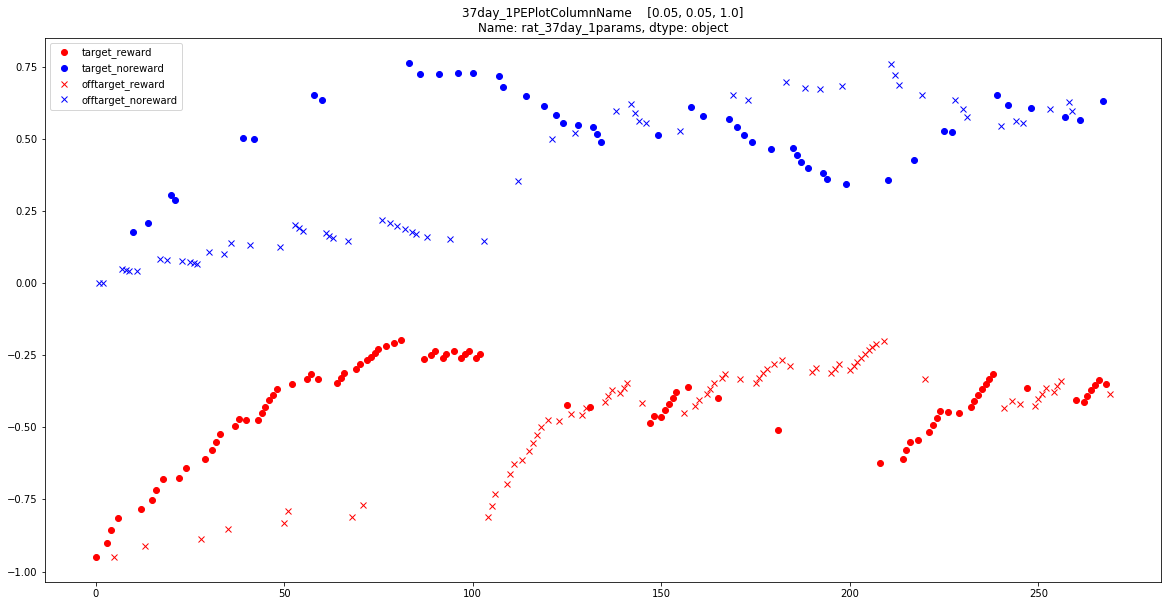

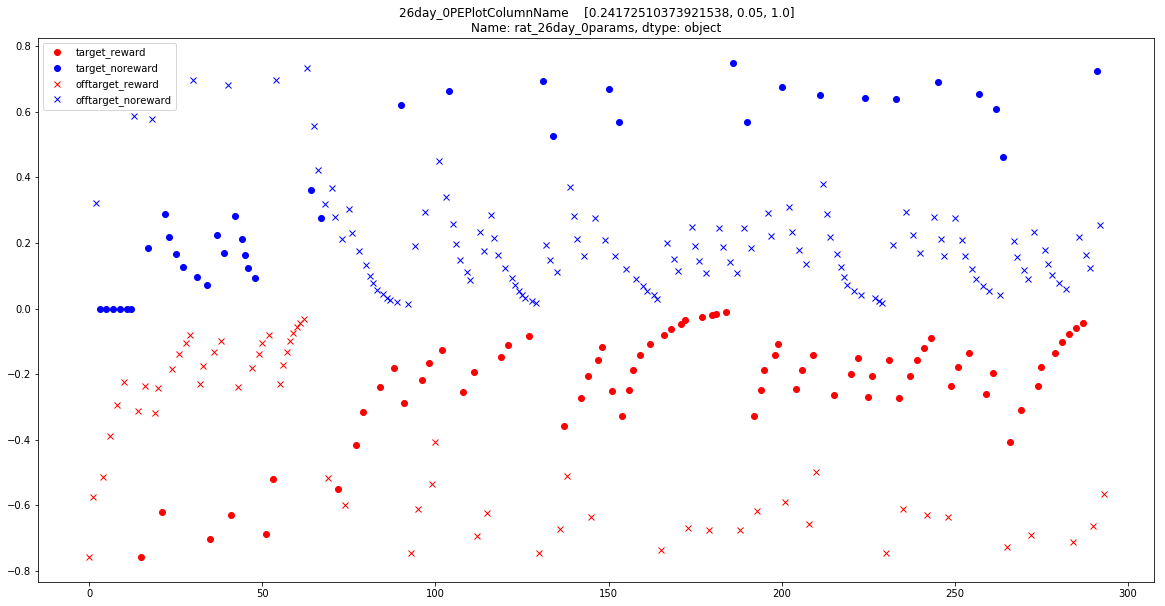

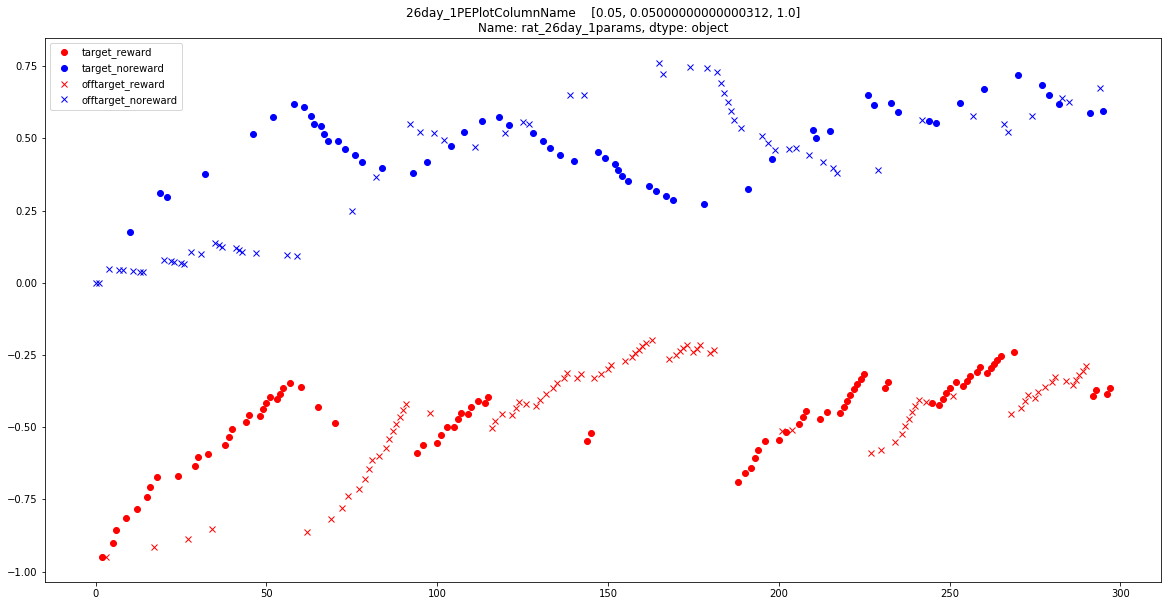

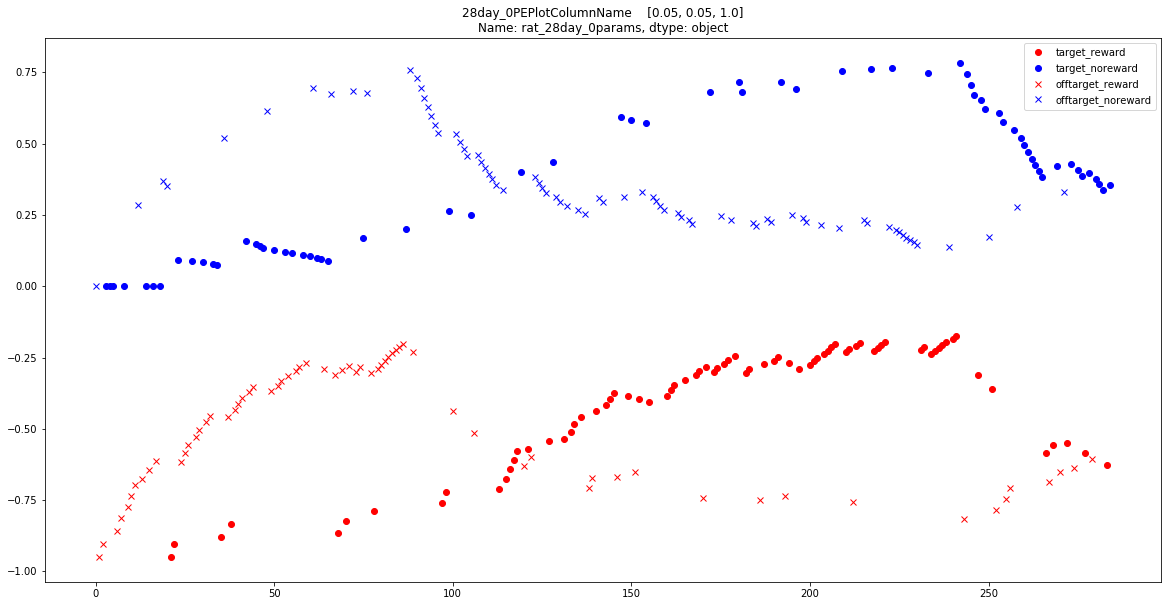

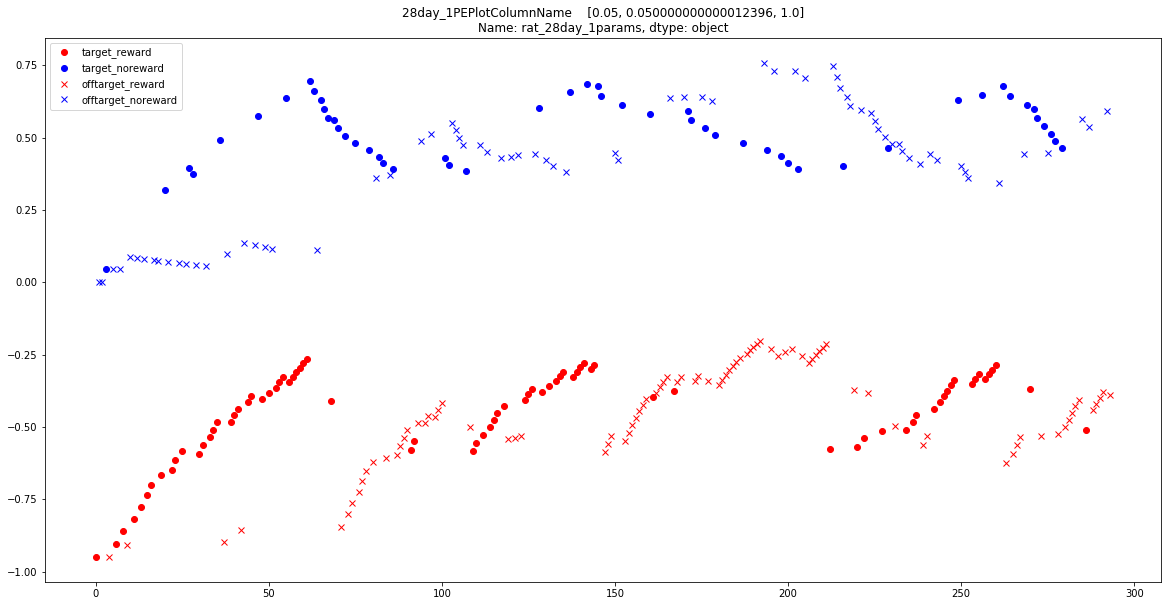

In [15]:
count=1
for rat in rat_2_anal:
    for day in range(days):
        tar_re,tar_no,off_re,off_no=[],[],[],[]
        flag='rat_'+str(rat)+'day_'+str(day)
        myPE=PELogs.loc[flag][0]
        action_log=behavior_log.loc[flag+'sideaction'][0]
        reward_log=behavior_log.loc[flag+'reward'][0]
        for i,x in enumerate(zip(action_log,reward_log)):
            if x==(1,1):
                tar_re.append([i,myPE[i][0]])
            elif x==(1,0):
                tar_no.append([i,myPE[i][0]])
            elif x==(2,1):
                off_re.append([i,myPE[i][0]])
            elif x==(2,0):
                off_no.append([i,myPE[i][0]])
        tar_re=np.array(tar_re)
        tar_no=np.array(tar_no)
        off_re=np.array(off_re)
        off_no=np.array(off_no)
        
        plt.figure(count,figsize=(20,10))
        mpara=PELogs.loc[flag+'params']
        plt.title(str(rat)+'day_'+str(day)+'PEPlot'+str(mpara))
        count+=1
        plt.plot(tar_re[:,0],tar_re[:,1],'ro')
        plt.plot(tar_no[:,0],tar_no[:,1],'bo')
        plt.plot(off_re[:,0],off_re[:,1],'rx')
        plt.plot(off_no[:,0],off_no[:,1],'bx')
        plt.legend(('target_reward','target_noreward','offtarget_reward','offtarget_noreward'))

# Part two: import EEG

# Correlation with PE
## Correlating the PE vector with every point on the epoch

# For each rat

# T-test (Buggy)
## The first one test aginst a random in the first 0.2s before the tone_onset

33
(288, 400)
(290, 400)
37
(282, 400)
(270, 400)
26
(294, 400)
(298, 400)
28
(285, 400)
(294, 400)


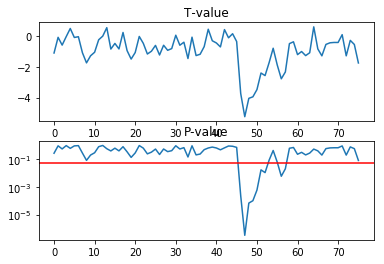

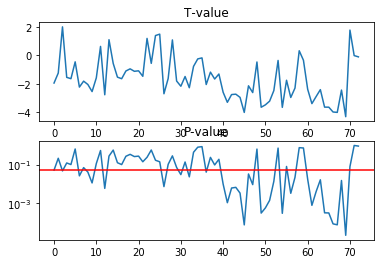

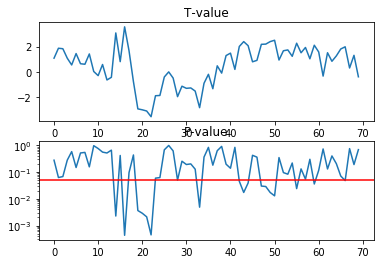

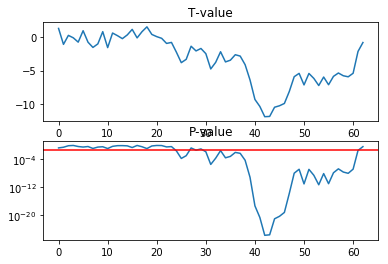

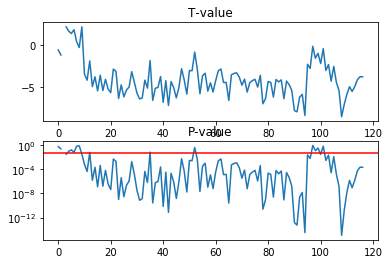

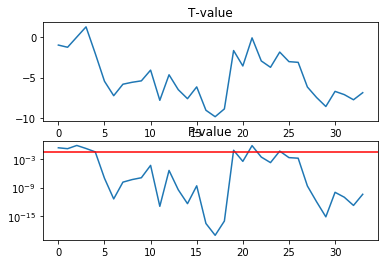

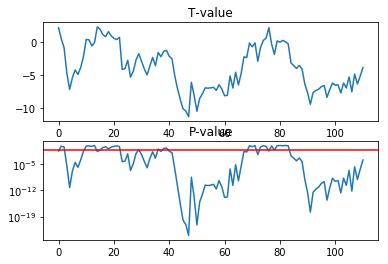

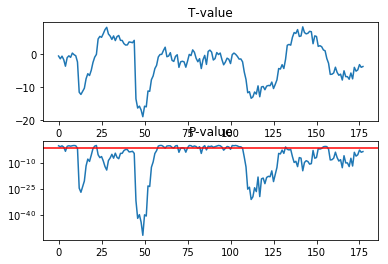

In [22]:
fs=500.0
dt=1/fs
indx=np.array([])
count=1
n=0
tvec=np.arange(0,dt*400,dt)-0.2
chan=19

cor={}

for rat in rat_2_anal:
    print(rat)
#     val_chan,chan_name,dates,rat_nums,reward_tone=IE.get_excel_info(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        epoched_eeg=EEGs[flag]
#         plt.plot(PELogs.iloc[n][0])
        myPE=PELogs.loc[flag][0]
#         plt.figure(count,figsize=(12,10))
#         count+=1
#         plt.subplot(2,1,1)
        action_log=behavior_log.loc[flag+'action'][0]
        reward_log=behavior_log.loc[flag+'reward'][0]
        
#         rat_df=IE.get_ephys(dates[day],rat_nums[day])
#         action_log,reward_log,epoched_eeg=IE.get_behavior(rat_df,300,plot=False);
        Tone=np.array(epoched_eeg['RE_epoch'])[:,chan,:]
    
        print(Tone.shape)
        
        temp=[]
        temptone=[]
        cor_temp=[]
        for i in range(400):
            res=stats.pearsonr(Tone[:,i],myPE.squeeze()) # correlate PE on each time point
            cor_temp.append(res)
            
            
        cor[flag]=np.array(cor_temp)
        cor_temp=np.array(cor_temp)
        sig_pval_onset=np.where(cor_temp[:,1]<0.05)[0] # where correlation is sig
        null=np.random.randint(0,100,len(sig_pval_onset))
        
        ttest=stats.ttest_rel(Tone[:,sig_pval_onset],Tone[:,null])
        
        
        
        plt.figure(count)
        count+=1
        plt.subplot(2,1,1)
        plt.plot(ttest[0])
        plt.title('T-value')
        plt.subplot(2,1,2)
        plt.plot(ttest[1])
        plt.axhline(y=0.05, color='r', linestyle='-')
        plt.yscale('log')
        plt.title('P-value')

        
        
        
        
#         erp1=IE.plot_average(tar_r,fil=False) # specify filter range here
#         erp2=IE.plot_average(off_r,fil=False)
#         erp3=IE.plot_average(tar_n,fil=False)
#         erp4=IE.plot_average(off_n,fil=False)
#         plt.title(str(dates[day])+', Rat:'+str(rat_nums[day])+'trigger_on_tone,chan_19')
#         plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))
#         plt.subplot(2,1,2)
#         IE.spec_plot(erp1)
#         IE.spec_plot(erp2)
#         IE.spec_plot(erp3)
#         IE.spec_plot(erp4)
#         plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))
#         plt.savefig(ERP_plot_path+str(rat_nums[day])+str(dates[day])+'_nofill_EEGplots.png', bbox_inches='tight')

# Correlation Plots

33
37
26
28


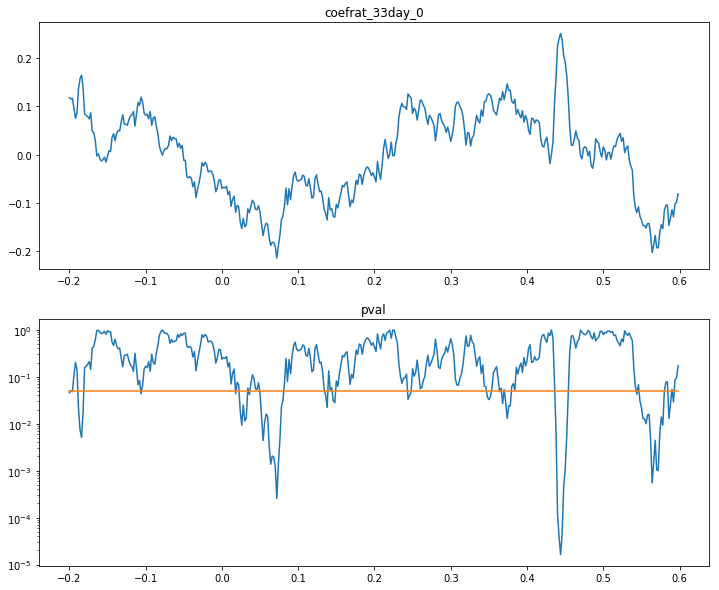

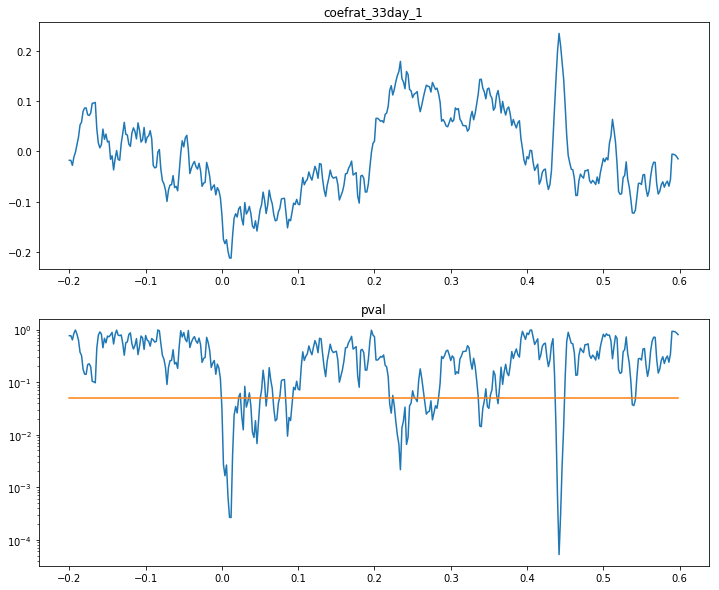

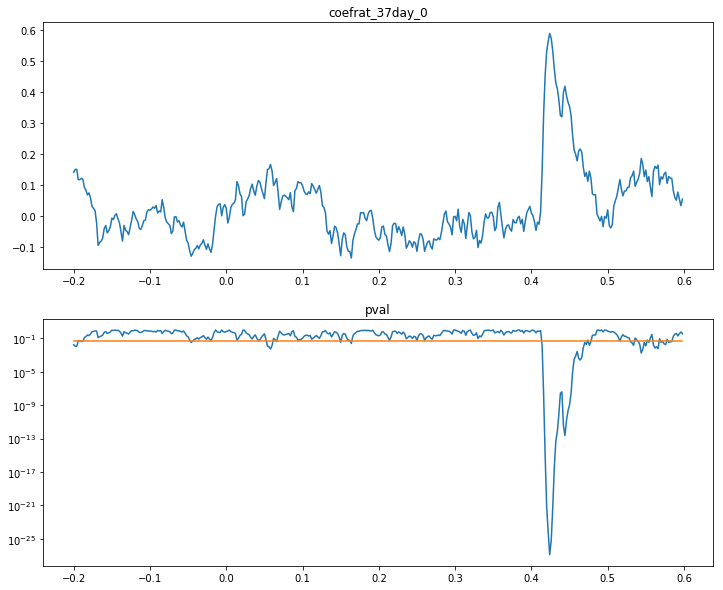

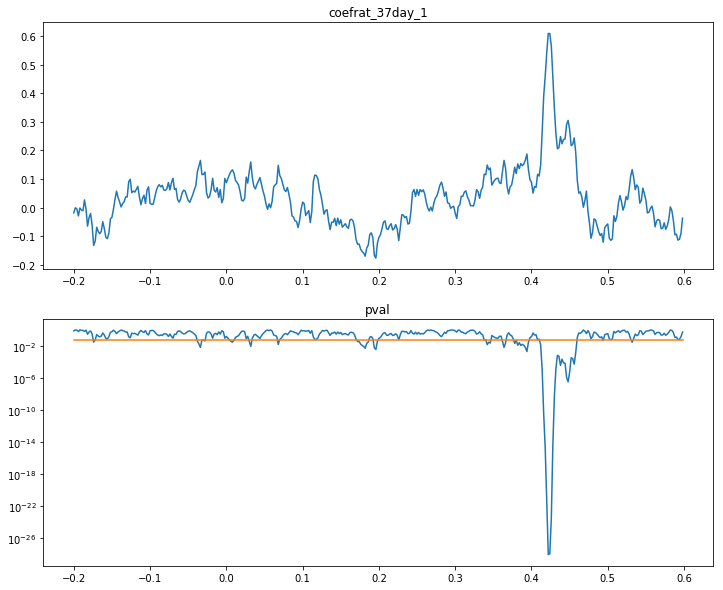

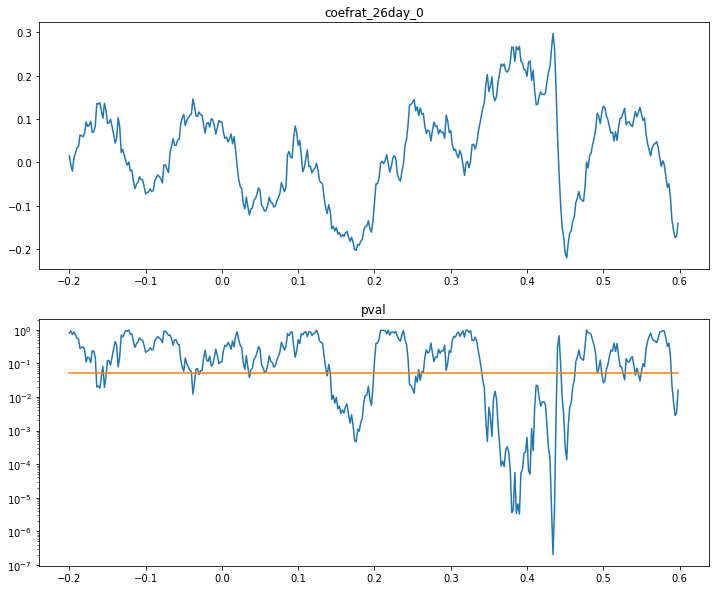

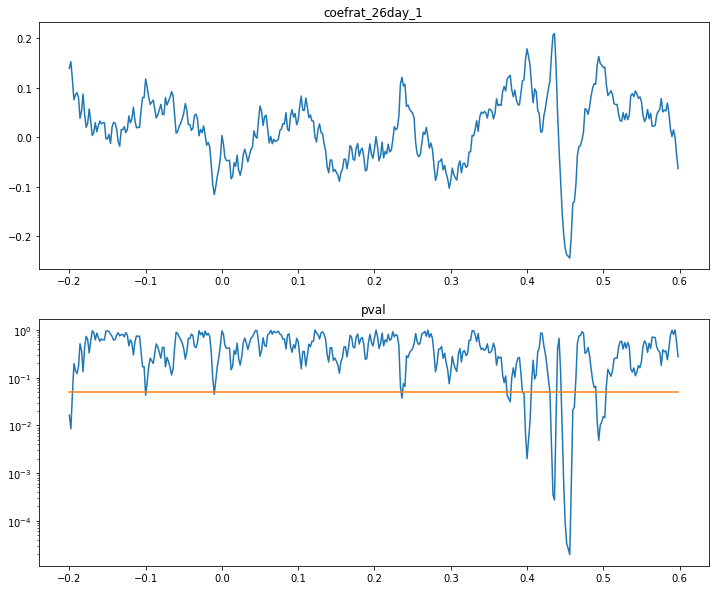

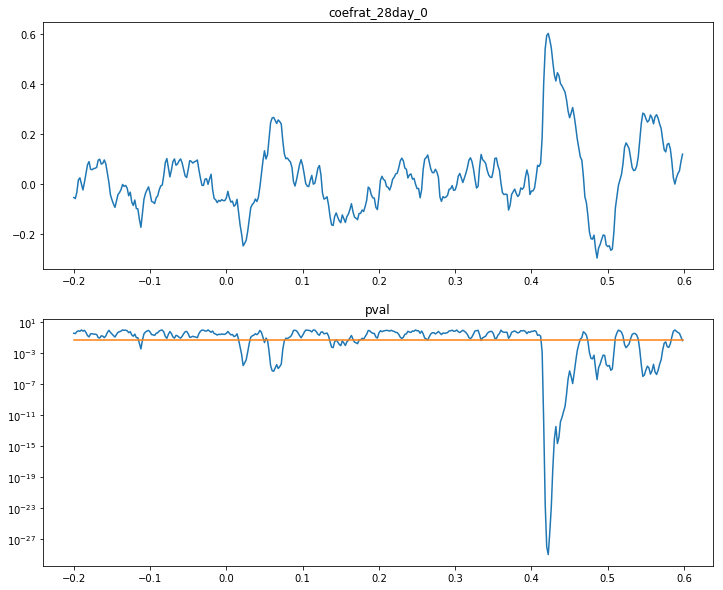

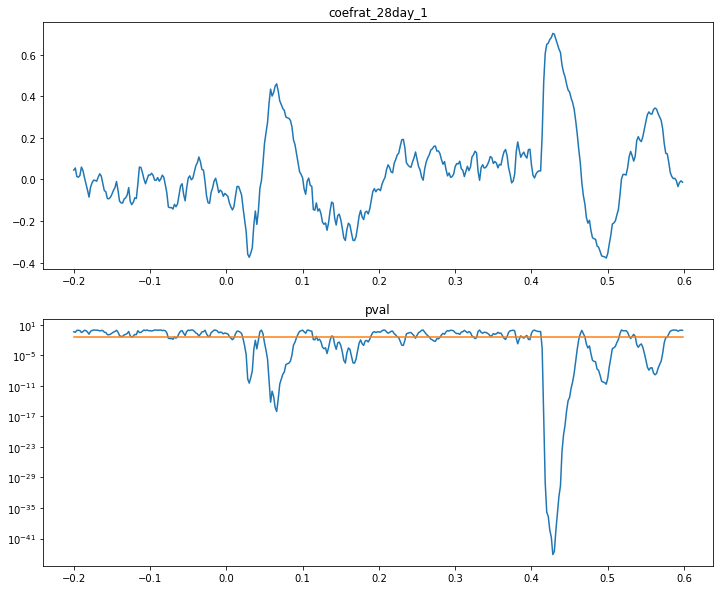

In [23]:
count=1
for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        
        coef=np.array(cor[flag])[:,0]
        pval=np.array(cor[flag])[:,1]

        plt.figure(count,figsize=(12,10))
        count+=1
        plt.subplot(2,1,1)
        plt.plot(tvec,coef)
        plt.title('coef'+str(flag))
        plt.subplot(2,1,2)
        plt.yscale('log')
        plt.plot(tvec,pval)
        plt.plot(tvec,np.full(400,.05))
        plt.title('pval')

# T-test over the entire thing

33
37
26
28


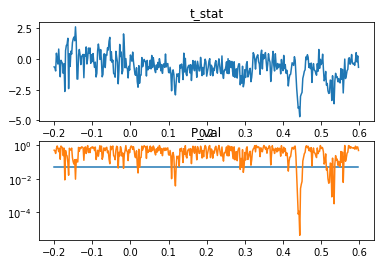

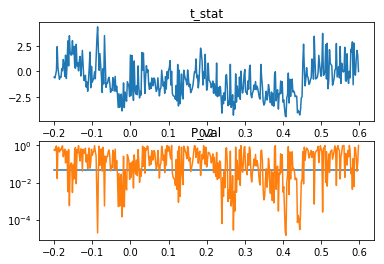

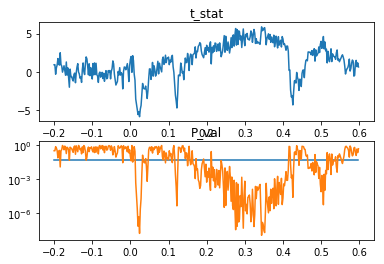

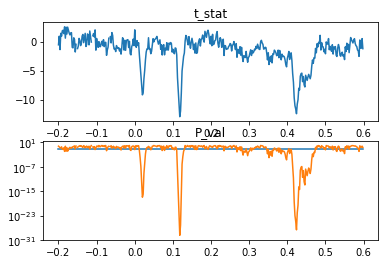

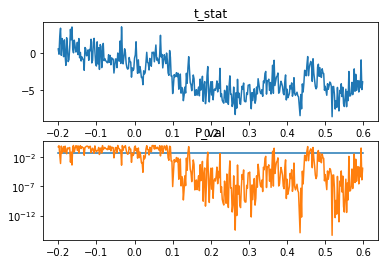

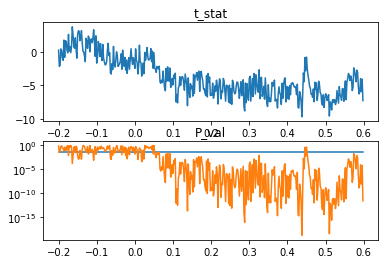

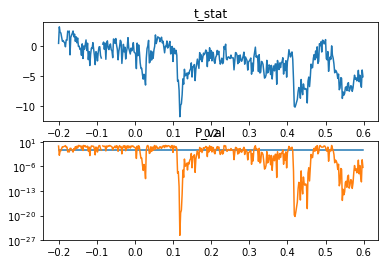

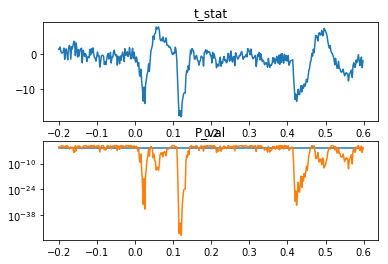

In [24]:
chan=19
tres={}
count=1
for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        epoched_eeg=EEGs[flag]
        Tone=np.array(epoched_eeg['RE_epoch'])[:,chan,:]
        tres_temp=[]
        for i in range(Tone.shape[1]):
            null=np.random.randint(0,100,1)[0]
            ttest=stats.ttest_rel(Tone[:,i],Tone[:,null])
            tres_temp.append([ttest[0],ttest[1]])
        plt.figure(count)
        count+=1
        tres_temp=np.array(tres_temp)
        tres[flag]=tres_temp
        plt.subplot(2,1,1)
        plt.title('t_stat')
        plt.plot(tvec,tres_temp[:,0])
        plt.subplot(2,1,2)
        plt.title('P_val')
        plt.plot(tvec,np.full(400,.05))
        plt.plot(tvec,tres_temp[:,1])
        plt.yscale('log')

# Grand Ttest

33
37
26
28


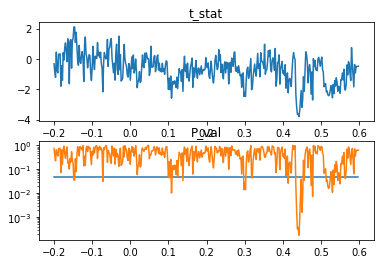

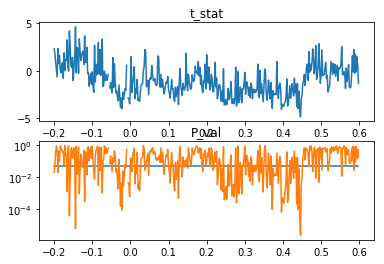

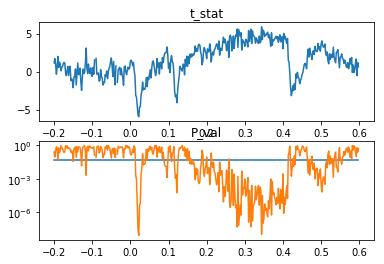

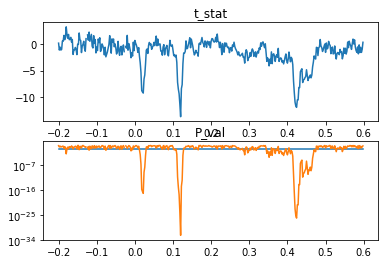

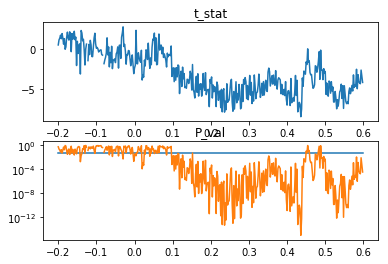

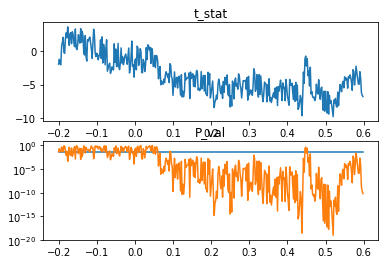

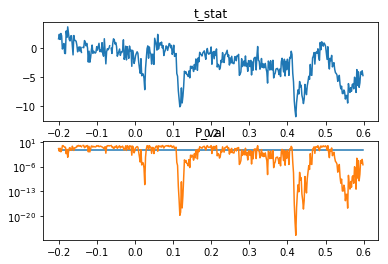

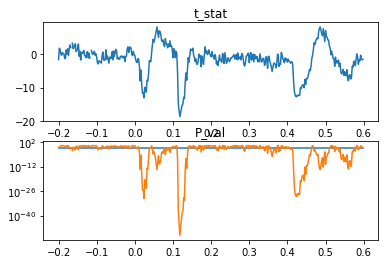

In [25]:
chan=19
count=1
for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        epoched_eeg=EEGs[flag]
        Tone=np.array(epoched_eeg['RE_epoch'])[:,chan,:]
        tres_temp=[]
        for i in range(Tone.shape[1]):
            null=np.random.randint(0,100,1)[0]
            ttest=stats.ttest_rel(Tone[:,i],Tone[:,null])
            tres_temp.append([ttest[0],ttest[1]])
        plt.figure(count)
        count+=1
        tres_temp=np.array(tres_temp)
        tres[flag]=tres_temp
        plt.subplot(2,1,1)
        plt.title('t_stat')
        plt.plot(tvec,tres_temp[:,0])
        plt.subplot(2,1,2)
        plt.title('P_val')
        plt.plot(tvec,np.full(400,.05))
        plt.plot(tvec,tres_temp[:,1])
        plt.yscale('log')

# Cluster by PE